## **EXPLORATORY DATA ANALYSIS** 
**EXP 01. AGGREGATED METRIC CLUSTERING** <br>
*ARGENTINIAN MAIZE INTERNATIONAL TRADE*

**DISCLAIMER:** <br>
*The data used for analyzing the market was obtained from the United Nations Stats and other open sources, the information and insights in the present document can't be used with commercial purposes keeping each data source with their original licences.*

**INTRODUCTION:** <br>
It is usual to find time series problems when we are working in business areas, those can be series about sales, stock levels, product demands or even data about machinery failures and maintenance. This kind of problem is used to be defined with high dimensional characteristics due to the granularity level that business requires and the main way to work with used to be aggregating the dataset with particular business metrics in a determined time period which misses part of the information contained in the dataset regarding the characteristics of the time series itself and about the relationships between the values among the timestamps, one clear example could be that you can lose information about the seasonality behaviour and the patterns among the analyzed dimensions.

Clustering algorithms as part of an Exploratory Data Analysis are powerful tools to identify hidden patterns in data and when working with time series we can take two approaches, the most frequent in my experience (and not necessarily the best) is the above-mentioned, aggregating the dataset but, we can bring to the analysis the time series characteristics using the proper techniques.
In this project, we are going to explore three clustering alternatives to work with time series using a dataset with the Argentinian Maize Exports by partner country:
* Aggregating the dataset and working with basic business metrics *(current notebook)*
* Working with the Dynamic Time Warping over the target variable time series
* Decomposing the time series into its three components


**OBJECTIVE:** <br>
Analyze the behaviour of basic aggregated metrics to identify hidden patterns in data using a clustering technique over the trade partners


**PIPELINE:** <br>
* Dataset transformation into a classification problem using aggregated metrics.
* Dataset preprocessing
* Optimal number of clusters definitions
* Partners clustering experiments and clusters definitions


### 00.00. RESOURCES AND WORK ENVIRONMENT SETTING

To develop this projects, we need to prepare the environment and that involves loading the required libraries and to defined the work directory where:

**Data Handling Libraries:**
* **pandas:** working with dataframes
* **numpy:** handling numbers

**Graphic Libraries:**
* **matplotlib:** creating graphic objects

**Clustering Resources:**
* **sklearn:** Machine Learning library, used to data preprocessing and also for clustering creation and definition

**General Config Libraries:**
* **os:** workdirectory path definition
* **warnings:** ignore warnings messages from libraries

#### 00.01. LIBRARIES AND WD

In [1]:
##-- ENVIRONMENT SETTINGS
import pandas as pd ; from pandas.tseries.offsets import MonthEnd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
##-- GENERAL SETTINGS
csvAttr_imp = {'sep': ';' , 'encoding': 'UTF-8'} #csv settings - export

cereal = 'Maize'
maxClusterNumbers = 10
randomStateValue = 2023
flowType = 'export' ; flowColumn = 't_exp' if flowType.lower() == 'export' else 't_imp'

In [3]:
##-- WORK DIRECTORY
wd = 'C:/Users/jrab9/OneDrive/08.Github/2023.HS10-ARG.Clustering/01.Data/'

os.chdir(wd)

#### 00.02 DATA

The dataset has been cleaned and curated for this problem in the file etl.py and it contains data for all partners in every single timestamp, for those months with no transactions the variables numeric will take 0 as value and it doesn’t contain any Null value.

In [4]:
##-- DATA
colsToDrop = ['valueByTonne_imp','logisticValue','reporterRegionDesc','reporterCode','partnerCode','un_code_l2']

df_base = pd.read_csv(wd + '/dfM.csv.gz', sep = csvAttr_imp['sep'], encoding = csvAttr_imp['encoding']).drop(columns = colsToDrop)
df_base['date'] = pd.to_datetime(df_base['date'], format = '%Y-%m-%d')

##-- FILTERS
df_base = df_base[df_base.date.dt.year.isin([2022,2021])].reset_index(drop = True)

##-- DATASET FACTS

dfShape = df_base.shape
dfMinDate = df_base.date.min().date()
dfMaxDate = df_base.date.max().date()
dfMonths = len(pd.date_range(dfMinDate,dfMaxDate, freq = 'm'))

print(f'Data Frame shape: {dfShape}')
print(f'Time series range from {dfMinDate} to {dfMaxDate} ({dfMonths} meses)')

Data Frame shape: (24576, 15)
Time series range from 2021-01-31 to 2022-12-31 (24 meses)


Where each variable mean is presented in the following data dictionary:

| **VAR NAME**              | **DESCRIPTION**                                                                                             |
|---------------------------|-------------------------------------------------------------------------------------------------------------|
| calendarCode              | code created with the year, month and last day of month for each mont in the time series range |
| reporterCodeISO           | reporter country ISO3 code |
| reporterDesc              | reporter country name |
| partnerCodeISO            | partner country ISO3 code |
| partnerDesc               | partner country name |
| partnerRegionDesc         | partner country region (curated by hand, is not an official category) where each country has only a region |
| desc_l2                   | cereal name |
| t_exp                     | quantity of exports (trade flow from reporter to partner) in tonnes |
| t_imp                     | quantity of imports (trade flow from partner to reporter) in tonnes |
| primaryValue_exp          | value FOB of total exports |
| primaryValue_imp          | value CIF of total imports (negative values) |
| tradeBalance              | sum of primaryValue_exp and primaryValue_imp (net value) |
| t_total                   | sum of t_exp + t_imp |
| valueByTonne_exp          | primaryValue_exp / t_exp |
| date                      | calendarCode converted to a date value |

### 01.00. TRANSFORMATIONS AND PREPROCESSING

In the current state, the dataset is not ready for clustering, now we have many time series appended in rows, and we need to prepare the dataset to be used in a classification problem, for this we are going to create some new variables as part of a basic featuring engineering strategy using like resources ratios, addition, and subtraction of current variables.

The main steps behind the transformation process are:
1. to aggregate annual metrics with the current variables
2. to identify the number of months with trade activities between the reporter and the partner
3. to create metrics as ratios of the target cereal related to the rest of the cereals traded with the partner.
4. To create the same variables from the past year


In [5]:
##-- CEREALS
df_base.desc_l2.unique()

array(['Maize', 'Wheat', 'Rice', 'Barley', 'Sorghum', 'Others', 'Oats',
       'Rye'], dtype=object)

In [6]:
#-CLEANING VARS
df_base.drop(columns = ['reporterCodeISO','reporterDesc','calendarCode'], inplace = True)
df_base.head(4)

,partnerCodeISO,partnerDesc,partnerRegionDesc,desc_l2,t_exp,t_imp,primaryValue_exp,primaryValue_imp,tradeBalance,t_total,valueByTonne_exp,date
0,DZA,Algeria,Africa,Maize,118891.00,0.000,22802230.72,-0.00,22802230.72,118891.000,191.791058,2021-01-31
1,CHL,Chile,South America,Wheat,41892.10,0.000,8735136.14,-0.00,8735136.14,41892.100,208.515117,2021-01-31
2,CHL,Chile,South America,Maize,99407.80,0.152,19178603.93,-1587.62,19177016.31,99407.952,192.928562,2021-01-31
3,CHL,Chile,South America,Rice,4176.68,0.000,1828216.40,-0.00,1828216.40,4176.680,437.720007,2021-01-31


In [7]:
#-NEW FEATURES
df_base['year'] = df_base['date'].dt.year

In [8]:
##-CALCULATING METRICS
indexColumns = ['partnerCodeISO','partnerDesc','partnerRegionDesc','year']

##-BASIC METRICS OF TARGET CEREAL
df_metrics = df_base[df_base['desc_l2'] == cereal]
df_metrics['trxExpOnMonth'] = df_metrics['t_exp'] != 0
df_metrics['trxImpOnMonth'] = df_metrics['t_imp'] != 0

df_metrics = df_metrics.groupby(indexColumns).agg(t_exp = ('t_exp','sum'),
                                                  t_imp = ('t_imp','sum'),
                                                  t_total = ('t_total','sum'),
                                                  trxExp = ('trxExpOnMonth','sum'),
                                                  trxImp = ('trxImpOnMonth','sum'),
                                                  valueByTonne_exp = ('valueByTonne_exp','mean')).reset_index().fillna(0)
df_metrics['exports'] = np.where(df_metrics['trxExp'] > 0, 1 , 0)
df_metrics['imports'] = np.where(df_metrics['trxImp'] > 0, 1 , 0)

##-BASIC METRICS OF ALL CEREALS
df_metric_aux = df_base.copy()
df_metric_aux['trxExpOnMonth'] = df_metric_aux['t_exp'] != 0
df_metric_aux['trxImpOnMonth'] = df_metric_aux['t_imp'] != 0

df_metric_aux = df_metric_aux.groupby(indexColumns).agg(t_exp_tot = ('t_exp','sum'),
                                                        t_imp_tot = ('t_imp','sum'),
                                                        t_total_tot = ('t_total','sum'),
                                                        trxExp_tot = ('trxExpOnMonth','sum'),
                                                        trxImp_tot = ('trxImpOnMonth','sum')).reset_index().fillna(0)

##-INCLUDING DATA FROM ALL CEREALS
df_metrics = df_metrics.merge(df_metric_aux.drop(columns = ['partnerDesc','partnerRegionDesc']), on = ['partnerCodeISO','year'] , how = 'left')

metricCols = df_metrics[df_metrics.columns[df_metrics.columns.isin(['partnerCodeISO','partnerDesc','partnerRegionDesc','year']) == False]].columns

df_metrics['t_exp%Cereal'] = np.round(df_metrics['t_exp'] / df_metrics['t_exp_tot'],1).fillna(0) * 100
df_metrics['t_imp%Cereal'] = np.round(df_metrics['t_imp'] / df_metrics['t_imp_tot'],1).fillna(0) * 100

for i in metricCols:
    df_metrics[i] = np.round(df_metrics[i],1)

df_metrics = df_metrics[df_metrics['year'] == 2022].reset_index(drop = True).drop(columns = ['year']).merge(df_metrics[df_metrics['year'] == 2021].reset_index(drop = True).drop(columns = ['year','partnerDesc','partnerRegionDesc']), on = 'partnerCodeISO', how = 'left', suffixes=('', '_PY'))
df_metrics.set_index(['partnerCodeISO','partnerDesc','partnerRegionDesc'], inplace = True)

df_metrics.head(4)

,,,t_exp,t_imp,t_total,trxExp,trxImp,valueByTonne_exp,exports,imports,t_exp_tot,t_imp_tot,...,valueByTonne_exp_PY,exports_PY,imports_PY,t_exp_tot_PY,t_imp_tot_PY,t_total_tot_PY,trxExp_tot_PY,trxImp_tot_PY,t_exp%Cereal_PY,t_imp%Cereal_PY
partnerCodeISO,partnerDesc,partnerRegionDesc,,,,,,,,,,,,,,,,,,,,,
AFG,Afghanistan,Asia,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0,0,0.0,0.0
AGO,Angola,Africa,107619.6,0.0,107619.6,8,0,256.1,1,0,107619.6,0.0,...,124.7,1,0,98346.4,0.0,98346.4,5,0,100.0,0.0
ALB,Albania,Europe,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0,0,0.0,0.0
ARE,United Arab Emirates,Asia,315562.2,0.0,315562.2,12,0,335.1,1,0,315562.2,0.0,...,228.7,1,0,467392.9,0.0,467392.9,10,0,100.0,0.0


Having the transformation or feature engineering process finished, considering we need to evaluate variables with different distributions, ranges and statistic characteristics the next step is to scale the dataset, for this, we are using the Z-Score normalization To homogenize the range of the variables and avoid potential misinterpretations due to each variable scale or differences.

Having tested different configurations of variables for this example we are only using the following metrics for clustering: 't_exp%Cereal','t_imp%Cereal','t_total','t_total_PY','trxExp','trxImp'

It is very important to consider that not every single created variable is going to improve the algorithm performance and the configuration of variables needs to be tested to determine if it is adding value to the clustering process.

In [9]:
##-- SCALING DATASET
df_metricsScaled = df_metrics[['t_exp%Cereal','t_imp%Cereal','t_total','t_total_PY','trxExp','trxImp']].copy()

normalizedValues = pd.DataFrame()

for var in df_metricsScaled.columns:
    scaler = StandardScaler()    
    df_metricsScaled[var] = scaler.fit_transform(df_metricsScaled[var].values.reshape(-1,1))
    
    mean = scaler.mean_
    std = scaler.scale_
    
    normalizedValues = normalizedValues.append({'var':var,
                                                'mean':mean[0],
                                                'std':std[0]}, ignore_index = True)    


df_metricsScaled.head(4)

,,,t_exp%Cereal,t_imp%Cereal,t_total,t_total_PY,trxExp,trxImp
partnerCodeISO,partnerDesc,partnerRegionDesc,,,,,,
AFG,Afghanistan,Asia,-0.797084,-0.243261,-0.303389,-0.308878,-0.651379,-0.284877
AGO,Angola,Africa,1.369090,-0.243261,-0.172160,-0.211232,1.265323,-0.284877
ALB,Albania,Europe,-0.797084,-0.243261,-0.303389,-0.308878,-0.651379,-0.284877
ARE,United Arab Emirates,Asia,1.369090,-0.243261,0.081401,0.155186,2.223674,-0.284877


### 02.00. CLUSTERING
#### 02.01. OPTIMAL NUMBER OF CLUSTERS

For this exercise, the k-means algorithm has been selected due to its interpretability (centroid means) and to the nature of the problem (unsupervised). Before creating the clusters, we need to answer a particular question: how many clusters do we need? this question could has multiple answers, and it depends on two main issues:
* Is there any need for the business? for example, this can be a determined number of clusters for a particular campaign. 
* If we don’t have any constraints or requirements, we can work supported with clustering quality metrics, visual analysis and considering business knowledge (this is a key piece to delivering better quality solutions)

To determine the optimal number of clustering we are going to use three metrics:
1. *Silhouette coefficient:* This coefficient considers the mean intra-cluster distance (cohesion) and the mean nearest-cluster distance (separation) for each sample and takes values between -1 and 1 where the highest values indicate better matches to its cluster.
2. *Calinski Harabasz Score:* This score is calculated considering the ratio of between-cluster dispersion and of within-cluster dispersion. The highest values indicate a better definition of the cluster.
3. *Davies Bouldin Index:* This index measures the average similarity between clusters comparing the distances between clusters with the size of the cluster. The lowest value possible is Zero and the closer the value to zero means a better cluster partition.

For further information, https://scikit-learn.org/stable/modules/clustering.html presents a good summary of clustering concepts.




In [10]:
##-- OPTIMAL CLUSTER NUMBERS
numberOfClusters = pd.DataFrame()    
X = df_metricsScaled.copy()  

for clusters in range(2,maxClusterNumbers + 1):
    kmeans = KMeans(n_clusters = clusters, random_state = randomStateValue).fit(X)
    labels = kmeans.labels_

    score_s = silhouette_score(X, labels)
    score_c = calinski_harabasz_score(X, labels)
    score_d = davies_bouldin_score(X, labels)

    numberOfClusters = numberOfClusters.append({'cereal': cereal,
                                                'clusters': clusters,
                                                'silhouetteScore': score_s,
                                                'calinskiHarabaszScore': score_c,
                                                'daviesBouldinScore': score_d,
                                                'flowType':flowType
                                                }, ignore_index = True) 
    
numberOfClusters['maxValueOf_S'] = numberOfClusters['silhouetteScore'] == numberOfClusters['silhouetteScore'].max()
numberOfClusters['maxValueOf_C'] = numberOfClusters['calinskiHarabaszScore'] == numberOfClusters['calinskiHarabaszScore'].max()
numberOfClusters['minValueOf_D'] = numberOfClusters['daviesBouldinScore'] == numberOfClusters['daviesBouldinScore'].min()

In [11]:
optimalNumberOfClusters = numberOfClusters[(numberOfClusters['maxValueOf_S']) | (numberOfClusters['maxValueOf_C']) | (numberOfClusters['minValueOf_D'])].reset_index(drop = True)
optimalNumberOfClusters = optimalNumberOfClusters.clusters.unique()
optimalNumberOfClusters

array([ 6,  9, 10], dtype=int64)

Each metric suggests a different number of optimal clusters (reaching 10 clusters which is the max number of clusters tested as part of the present project), in this case, we could test other variables configurations or analyses deeply the results of these configurations to determine if it is solving our problem. 

|**METRIC**             | **#CLUSTERS**|
|-----------------------|--------------|
|Silohuette Index       | 6 Clusters |
|Calinski Harabasz Score| 9 Clusters |
|Davies-Bouldin Index   | 10 Clusters |


#### 02.02. CLUSTERING BY K-MEANS
The K-means algorithm has been selected due to its interpretability; each cluster has a centroid with the mean value for each evaluated variable. Once the optimal number of clusters to test has been determined we are going to evaluate the results by getting a look at each cluster centroid.

In [12]:
##--CLUSTERING
Y = X.copy().reset_index()
newColumns = []
kmeansCenters = pd.DataFrame()

for numClusters in optimalNumberOfClusters:
    clusterTag = f'{numClusters}_clusters'
    
    kmeans = KMeans(n_clusters = numClusters, random_state = randomStateValue).fit(X)
    labels = kmeans.labels_
    centers = pd.DataFrame(kmeans.cluster_centers_, columns = X.columns)
    centers['cluster'] = centers.index
    centers['exp'] = clusterTag           
    
    Y[clusterTag] = labels
    centers['partners'] = Y.groupby(clusterTag).size().values ##-PARTNERS BY CLUSTERS
    
    kmeansCenters = kmeansCenters.append(centers).reset_index(drop = True)
    newColumns = np.append(newColumns,clusterTag)
    
    df_metrics = df_metrics.merge(Y[['partnerCodeISO',clusterTag]], on = 'partnerCodeISO', how = 'left').set_index('partnerCodeISO')
    df_metricsScaled = df_metricsScaled.merge(Y[['partnerCodeISO',clusterTag]], on = 'partnerCodeISO', how = 'left').set_index('partnerCodeISO')
                                  
newColumns

array(['6_clusters', '9_clusters', '10_clusters'], dtype='<U32')

In [13]:
##-DE-SCALING VARS (CENTERS) - IN THOUSANDS OF TONNES
kmeansCentersDeScaling = kmeansCenters.copy()

for var in kmeansCentersDeScaling.columns[:-3]:
    kmeansCentersDeScaling[var] = np.ceil((kmeansCentersDeScaling[var] * normalizedValues[normalizedValues['var'] == var]['std'].values[0]) + normalizedValues[normalizedValues['var'] == var]['mean'].values[0])

#### 02.03. 6 CLUSTERS

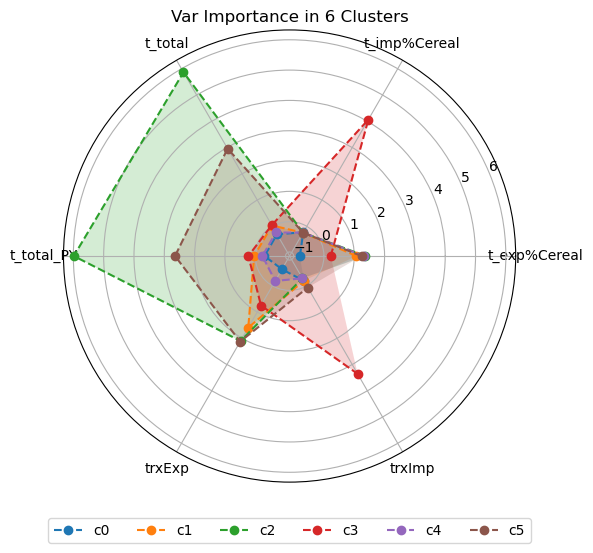

,t_exp%Cereal,t_imp%Cereal,t_total,t_total_PY,trxExp,trxImp,cluster,partners
0,1.0,1.0,168.0,4269.0,1.0,1.0,0,74
1,87.0,1.0,272725.0,348822.0,10.0,1.0,1,19
2,100.0,0.0,5060619.0,6339678.0,12.0,0.0,2,2
3,48.0,88.0,283475.0,540587.0,6.0,9.0,3,7
4,99.0,0.0,56051.0,73087.0,2.0,1.0,4,21
5,94.0,0.0,2674092.0,2975649.0,12.0,1.0,5,5


In [14]:
##-EXP-01
clusterTag = optimalNumberOfClusters[0]
df_plot = kmeansCenters[kmeansCenters['exp'] == f'{clusterTag}_clusters'].copy().drop(columns = ['exp','partners'])

subjects = df_plot[df_plot.columns[:-1]].columns
angles=np.linspace(0,2*np.pi,len(subjects), endpoint=False)

fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(polar=True)

for cluster in df_plot.cluster.unique():    
    label_ = f'c{cluster}'
    c = df_plot[df_plot['cluster'] == cluster].reset_index(drop = True).drop(columns = ['cluster']).values[0]    
    #CLUSTER
    ax.plot(angles,c, 'o--', label=label_)
    ax.fill(angles, c, alpha=0.20)

ax.set_thetagrids(angles * 180/np.pi, subjects)
plt.grid(True)
plt.tight_layout()
plt.legend(ncol = clusterTag, loc = 'lower center',bbox_to_anchor=(0.5,-0.15))
plt.title(f'Var Importance in {clusterTag} Clusters')
plt.show()

display(kmeansCentersDeScaling[kmeansCenters['exp'] == f'{clusterTag}_clusters'].copy().drop(columns = ['exp']).reset_index(drop = True))

Each cluster presents clear differences in its characteristics:

**Cluster 0:** High volume of partners with a non-important relevance (speaking in terms of the volume) individually due to their trade value and the number of months with commerce in a 12-month period. We can interpret this cluster as spot partners with low volume and frequency (almost null). <br>
**Cluster 1:** High dependency on Maize in the total cereal export flow with those partners and low importance in the import flow, partners with high trade frequency. Stable partners with a mid-volume flow. <br>
**Cluster 2:** Few countries with a higher average export level and a higher (100%) dependency on Maize in the Argentinian cereals export flow. Stable partners with transactions every month in a year. <br>
**Cluster 3:** Partners with an important impact of maize in both flows (import and exports) but with bigger average importance of maize in the import flows (independent of total volume). Those partners have more months with import transactions than export transactions in a year. <br>
**Cluster 4:** Minor partners in terms of volume and dependence on maize in the exports of total cereal flow and spot partners due to their frequency characteristics. <br>
**Cluster 5:** Second group on average volume and stable partners of high frequency (12/12 months with transactions) and with a high dependence on Maize in the total exports of cereals. <br>
In general terms, the annual volume of sales has decreased in the last year, all centroids in the current year for t_total are lower than t_total_PY (Past Year)


#### 02.03. 9 CLUSTERS

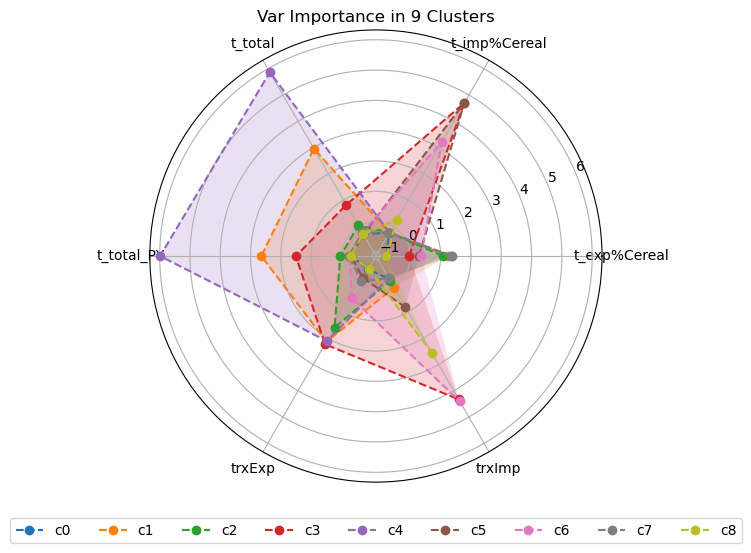

,t_exp%Cereal,t_imp%Cereal,t_total,t_total_PY,trxExp,trxImp,cluster,partners
0,1.0,1.0,172.0,4383.0,1.0,1.0,0,72
1,94.0,0.0,2674092.0,2975649.0,12.0,1.0,1,5
2,87.0,1.0,272725.0,348822.0,10.0,1.0,2,19
3,35.0,100.0,916902.0,1827630.0,12.0,11.0,3,2
4,100.0,0.0,5060619.0,6339678.0,12.0,0.0,4,2
5,50.0,100.0,388.0,0.0,2.0,3.0,5,2
6,54.0,70.0,49914.0,42948.0,5.0,11.0,6,3
7,99.0,0.0,56051.0,73087.0,2.0,1.0,7,21
8,0.0,10.0,8.0,161.0,0.0,7.0,8,2


In [15]:
##-EXP-02
clusterTag = optimalNumberOfClusters[1]
df_plot = kmeansCenters[kmeansCenters['exp'] == f'{clusterTag}_clusters'].copy().drop(columns = ['exp','partners'])

subjects = df_plot[df_plot.columns[:-1]].columns
angles=np.linspace(0,2*np.pi,len(subjects), endpoint=False)

fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(polar=True)

for cluster in df_plot.cluster.unique():    
    label_ = f'c{cluster}'
    c = df_plot[df_plot['cluster'] == cluster].reset_index(drop = True).drop(columns = ['cluster']).values[0]    
    #CLUSTER
    ax.plot(angles,c, 'o--', label=label_)
    ax.fill(angles, c, alpha=0.20)

ax.set_thetagrids(angles * 180/np.pi, subjects)
plt.grid(True)
plt.tight_layout()
plt.legend(ncol = clusterTag, loc = 'lower center',bbox_to_anchor=(0.5,-0.15))
plt.title(f'Var Importance in {clusterTag} Clusters')
plt.show()

display(kmeansCentersDeScaling[kmeansCenters['exp'] == f'{clusterTag}_clusters'].copy().drop(columns = ['exp']).reset_index(drop = True))

In this test, cluster 0 presents only a few average changes and it is interesting to observe that four clusters preserve their characteristics between peer's experiments:
|CURRENT TEST | EQUIVALENT|
|---|---|
| 0 |   | 
| 1 | 5 |
| 2 | 1 |
| 3 |   |
| 4 | 2 |
| 5 |   |
| 6 |   |
| 7 | 4 |
| 8 |   |

the changes generate clusters with few partners, for this reason, we prefer 6 clusters rather than 9, the results will be exported to be presented in an exploratory dashboard with the other clustering experiments results.

### 03.00. EXPORT

In [16]:
selectedExperiment = '6_clusters'

df_export = df_metrics[selectedExperiment].reset_index().rename(columns = {selectedExperiment:'clusterByMetrics'})
df_export['cereal'] = cereal
df_export.to_csv(wd + f'/clustersExp01.csv.gz', index = False, sep = csvAttr_imp['sep'], encoding = csvAttr_imp['encoding'])
df_export.head()

,partnerCodeISO,clusterByMetrics,cereal
0,AFG,0,Maize
1,AGO,1,Maize
2,ALB,0,Maize
3,ARE,1,Maize
4,ARG,0,Maize


In [17]:
df_export_centers = kmeansCenters[kmeansCenters['exp'] == selectedExperiment].drop(columns = ['exp','partners'])
df_export_centers['cereal'] = cereal
df_export_centers.to_csv(wd + f'/clustersExp01_centers.csv.gz', index = False, sep = csvAttr_imp['sep'], encoding = csvAttr_imp['encoding'])
df_export_centers.head()

,t_exp%Cereal,t_imp%Cereal,t_total,t_total_PY,trxExp,trxImp,cluster,cereal
0,-0.794157,-0.229903,-0.303185,-0.304640,-0.628716,-0.183950,0,Maize
1,1.072666,-0.243261,0.029165,0.037459,1.593180,-0.192387,1,Maize
2,1.369090,-0.243261,5.867416,5.985652,2.103880,-0.284877,2,Maize
3,0.224112,4.063734,0.042273,0.227858,0.751921,3.355273,3,Maize
4,1.327829,-0.243261,-0.235043,-0.236312,-0.183613,-0.284877,4,Maize


In [19]:
df_metrics.reset_index().to_csv(wd + f'/df_metrics.csv.gz', index = False, sep = csvAttr_imp['sep'], encoding = csvAttr_imp['encoding'])
df_metrics.head()

,t_exp,t_imp,t_total,trxExp,trxImp,valueByTonne_exp,exports,imports,t_exp_tot,t_imp_tot,...,t_exp_tot_PY,t_imp_tot_PY,t_total_tot_PY,trxExp_tot_PY,trxImp_tot_PY,t_exp%Cereal_PY,t_imp%Cereal_PY,6_clusters,9_clusters,10_clusters
partnerCodeISO,,,,,,,,,,,,,,,,,,,,,
AFG,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0,0,1
AGO,107619.6,0.0,107619.6,8,0,256.1,1,0,107619.6,0.0,...,98346.4,0.0,98346.4,5,0,100.0,0.0,1,2,4
ALB,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0,0,1
ARE,315562.2,0.0,315562.2,12,0,335.1,1,0,315562.2,0.0,...,467392.9,0.0,467392.9,10,0,100.0,0.0,1,2,4
ARG,0.0,11.5,11.5,0,5,0.0,0,1,0.0,209.3,...,0.0,1068.8,1068.8,0,15,0.0,30.0,0,8,8
